### Full Name :moein samadi azad
### Student Number :400105093
___

# Problem
In this project our goal is to develop a framework for simple neural network and multi layer perceptron. We are going to use only `numpy` and no other packages to build our own classes and network.

# Setup

In [28]:
###################################
#  Do Not Add any other packages  #
###################################

import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import tqdm
import copy
from abc import ABC, abstractmethod
from sklearn.datasets import fetch_openml # just for downloading the dataset (MNIST)

plt.style.use('ggplot')

# Section 1: Modules implementation (65 Points)
We are going to implement the required modules for a neural network. Each of these modules must implement the necessary functions, `_forward` and `backward`. In the following parts, we will implement the `LinearLayer`, `ReLU`, `batchnorm`, `dropout`, and `SoftMax` layers.

## Layers

In [29]:
###################################
#     Do Not change this cell     #
###################################

class Module(ABC):
    def __call__(self, *args):
        return self._forward(*args)

    @abstractmethod
    def _forward(self, *args):
        pass
        

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

#### Linear Layer (5 Points)

The `LinearLayer` class represents a linear (fully connected) layer in a neural network. This layer computes the linear transformation of the input data as Wx + b, where W is the weight matrix, x is the input data, and b is the bias vector.

In [30]:
class LinearLayer(Module):
    """
    A linear layer module that calculates (Wx + b).
    """

    def __init__(self, dim_in, dim_out, initializer, reg, alpha):
        """
        Args:
            - dim_in: input dimension,
            - dim_out: output dimension,
            - initializer: a function that takes (dim_in, dim_out) and initialize a [dim_in x dim_out] matrix,
            - reg: L2-regularization flag
            - alpha: L2-regularization coefficient
        """
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.params = {
            'W': initializer(dim_in, dim_out),
            'b': np.zeros(dim_out),
            'reg': alpha if reg else 0,
        }
        self.grads = dict()
        self.cache = dict()

    def _forward(self, x, mode='train'):
        """
        linear forward function, calculates Wx+b for a batch of data

        Args:
            x : a batch of data
            mode: the step of training which can be train, valid and test

        Note:
            you need to store some values in cache to be able to
            calculate backward path.
        """
        #####################################################
        ##        Forward function for linear layer        ##
        ####################[Your Code]###################### 
        out = x @ self.params["W"] + self.params["b"]
        self.cache["x"] = x

        return out

    def backward(self, upstream):
        """
        gets upstream gradient and returns downstream gradient

        Args:
            upstream : upstream gradient of loss w.r.t module output

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        #####################################################
        ##        Backward function for linear layer       ##
        ####################[Your Code]######################
        W = self.params["W"]
        x = self.cache["x"]
        
        self.grads["x"] = upstream @ W.T 
        self.grads["W"] = x.T @ upstream
        self.grads["reg"] = 2 * self.params['reg'] * W
        self.grads["b"] = upstream.sum(axis=0)

In [31]:
###################################
#     Do not change this cell     #
#   output must be from o(e-5)    #
###################################

def check_gradient_linear(linear, h=0.00001):
    np.random.seed(121212)
    x = np.random.normal(size=(20, linear.dim_in))
    upstream = np.random.random(size=(20, linear.dim_out))

    new_x = x + h
    new_w = linear.params['W'] + h
    new_b = linear.params['b'] + h
    new_linear = copy.deepcopy(linear)
    new_linear.params['W'] = new_w
    new_linear.params['b'] = new_b
    new_val = new_linear(new_x)
    old_val = linear(x)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    linear.backward(upstream)
    delta_loss_direct = np.sum(h * linear.grads['x'])
    delta_loss_direct += np.sum(h * linear.grads['W'])
    delta_loss_direct += np.sum(h * linear.grads['b'])

    print(f'Relative error of delta-loss (for linear unit):\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

    old_val = np.sum(np.power(linear.params['W'], 2))
    new_val = np.sum(np.power(new_w, 2))
    indirect_loss = new_val - old_val
    direct_loss = np.sum(h * linear.grads['reg'])
    print(f'Relative error of delta-loss (for regularization):\n{rel_error(indirect_loss, direct_loss)}')

def initializer(x, y): return np.random.normal(size=(x, y))

linear = LinearLayer(5, 10, initializer, reg=True, alpha=1)
check_gradient_linear(linear, h=0.00001)

Relative error of delta-loss (for linear unit):
1.064447248348604e-05
Relative error of delta-loss (for regularization):
9.417674890879862e-06


#### ReLU Layer (5 Points)

The `ReLU` class represents a Rectified Linear Unit (ReLU) activation function, which is commonly used in neural networks to introduce non-linearity. This method applies the ReLU activation function to the input data x. The ReLU function is defined as ReLU(x) = max(0, x) meaning that it outputs the input directly if it is positive, otherwise it outputs zero.

In [32]:
class ReLU(Module):
    """
    Rectified Linear Unit function
    """

    def __init__(self):
        self.cache = dict()
        self.grads = dict()

    def _forward(self, x, mode='train'):
        """
        applies relu function on x

        Args:
            x : a batch of data
            mode: the step of training which can be train, valid and test

        Returns:
            y : relu of input
        """
        #####################################################
        ##         Forward function for ReLU layer         ##
        ####################[Your Code]######################
        y = np.maximum(0, x)
        self.cache['x'] = x
        return y
    

        

    def backward(self, upstream):
        """
        calculate and store gradient of loss w.r.t module input

        Args:
            upstream : gradient of loss w.r.t modele output

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        #####################################################
        ##         Backward function for ReLU layer        ##
        ####################[Your Code]######################
        x = self.cache['x']
        self.grads['x'] = (x > 0) * upstream
        return self.grads['x']
    

In [33]:
###################################
#     Do not change this cell     #
#   output must be from o(e-8)    #
###################################

def check_gradient_relu(rl, h=0.0001):
    np.random.seed(11111)
    x = np.random.normal(size=(10, 5))
    upstream = np.random.random(size=(10, 5))

    new_x = x + h
    new_val = rl(new_x)
    old_val = rl(x)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    rl.backward(upstream)
    delta_loss_direct = np.sum(h * rl.grads['x'])

    print(f'Relative error of delta-loss:\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

relu = ReLU()
check_gradient_relu(relu)

Relative error of delta-loss:
2.484727903125079e-14


#### SoftMax Layer (10 Points)

We could have a layer that calculates softmax for us. In other word, for input $x\in\mathcal{R}^N$ it would return $y\in\mathcal{R}^n$ where $y_i = \frac{e^{x_i}}{\sum e^{x_i}}$. But this method is not numerical stable because $e^{x_i}$ in this formulation can get very large easly and return `nan`. Instead of that we will implement a logarithmic version of softmax which instead of calculating $\frac{e^{x_i}}{\sum e^{x_i}}$, will calculate $\log\left(\frac{e^{x_i}}{\sum e^{x_i}}\right) = x_i - \log\sum e^{x_i}$. In order to calculate second term you can use `np.logaddexp` but this function only works on two inputs. For more than two inputs, fill in the following function to be able to calculate log sum exp of an array of shape (b,n). `axis=1` means sum over columns and `axis=0` sum over rows.

In [34]:
import numpy as np

def logsumexp(array, axis=1):
    """
    Calculate log(sum(exp(array))) using np.logaddexp to ensure numerical stability.

    Args:
        array : input array
        axis : reduce axis, 1 means columns and 0 means rows
    """
    # Get the maximum value along the specified axis to improve numerical stability
    max_val = np.max(array, axis=axis, keepdims=True)

    # Subtract the maximum value to prevent exponential overflow
    stable_array = array - max_val

    # Exponentiate the stabilized array
    exp_array = np.exp(stable_array)

    # Sum the exponentiated values along the specified axis
    sum_exp = np.sum(exp_array, axis=axis, keepdims=True)

    # Compute log of sum of exponentials and then add back the max value used for stabilization
    result = np.log(sum_exp) + max_val

    # Remove the extra dimension added by keepdims if necessary
    if not np.isscalar(result):
        result = np.squeeze(result, axis=axis)

    return result


In [35]:
class LogSoftMax(Module):
    def __init__(self):
        self.cache = dict()
        self.grads = dict()

    def _forward(self, x, mode='train'):
        """
        get x and calculate softmax of that.

        Args:
            x : batch of data with shape (b,m)
            mode: the step of training which can be train, valid and test

        Returns:
            y : log softmax of x with shape (b,m)
        """
        #####################################################
        ##      Forward function for LogSoftMax layer      ##
        ####################[Your Code]######################
        max_x = np.max(x, axis=1, keepdims=True)
        stabilized_x = x - max_x
        sum_exp = np.sum(np.exp(stabilized_x), axis=1, keepdims=True)
        log_sum_exp = np.log(sum_exp)
        log_softmax = stabilized_x - log_sum_exp

        if mode == 'train':
            self.cache['x'] = x
            self.cache['log_softmax'] = log_softmax

        return log_softmax

        

    def backward(self, upstream):
        """
        calculate gradient of loss w.r.t module input and save that in grads.

        Args:
            upstream : gradient of loss w.r.t module output with sahpe (b,m)

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        #####################################################
        ##     Backward function for LogSoftMax layer      ##
        ####################[Your Code]######################
        x = self.cache['x']
        log_softmax = self.cache['log_softmax']
        softmax = np.exp(log_softmax)

        # Gradient of the log softmax
        dx = softmax * (upstream - np.sum(upstream * softmax, axis=1, keepdims=True))

        self.grads['x'] = dx

        return dx
    

In [36]:
###################################
#     Do not change this cell     #
#   output must be from o(e-7)    #
###################################

def check_gradient_softmax(sm, h=0.0001):
    np.random.seed(321321)
    x = np.random.random(size=(10, 5))
    upstream = np.random.random(size=(10, 5))

    new_x = x + h
    new_val = sm(new_x)
    old_val = sm(x)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    sm.backward(upstream)
    delta_loss_direct = np.sum(h * sm.grads['x'])

    print(f'Relative error of delta-loss:\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

sm = LogSoftMax()
check_gradient_softmax(sm)

Relative error of delta-loss:
1.3446648037662018e-12


#### BatchNorm Layer (10 Points)

The `BatchNorm` class represents a batch normalization layer, which normalizes the inputs of each mini-batch to have zero mean and unit variance, and then scales and shifts them using learned parameters.
<br>
In `train` mode, this method:
<br>
Computes the mean and variance of the current batch. Normalizes the input batch using the batch statistics. Scales and shifts the normalized batch using the `gamma` and `beta` parameters. Updates the running mean and variance using the computed batch statistics.
<br>
In `valid` or `test` mode, this method:
<br>
Normalizes the input batch using the running mean and variance. Scales and shifts the normalized batch using the `gamma` and `beta` parameters.

In [37]:
class BatchNorm(Module):
    def __init__(self, dim_in, momentum=0.99, eps=1e-3):
        """
        Batch normalization layer for neural networks.
        Args:
            dim_in: Input dimension.
            momentum: Momentum for moving average of mean and variance.
            eps: Small constant to prevent division by zero.
        """
        self.cache = dict()
        self.grads = dict()
        self.momentum = momentum
        self.eps = eps
        self.dim_in = dim_in
        self.params = {
            'gamma': np.ones(dim_in),
            'beta': np.zeros(dim_in),
            'running_mean': np.zeros(dim_in),
            'running_var': np.zeros(dim_in),
        }

    def _forward(self, x, mode='train'):
        """
        gets x and calculates batchnorm of that.

        Args:
            x : batch of data with shape (b,m)
            mode: the step of training which can be train, valid and test

        Returns:
            y : log batchnorm of x with shape (b,m)
        """
        #####################################################
        ##      Forward function for Batchnorm layer       ##
        ####################[Your Code]######################
        if mode == 'train':
            self.params['running_mean'] = self.momentum * self.params['running_mean'] + (1 - self.momentum) * np.mean(x, axis=0)
            self.params['running_var'] = self.momentum * self.params['running_var'] + (1 - self.momentum) * np.var(x, axis=0)
            normalized = (x - np.mean(x, axis=0)) / np.sqrt(np.var(x, axis=0) + self.eps)
            self.cache['x'] = x
            self.cache['x_normalized'] = normalized
            self.cache['batch_mean'] = np.mean(x, axis=0)
            self.cache['batch_var'] = np.var(x, axis=0)
            return self.params['gamma'] * normalized + self.params['beta']

        normalized = (x - self.params['running_mean']) / np.sqrt(self.params['running_var'] + self.eps)
        return self.params['gamma'] * normalized + self.params['beta']
        
    def backward(self, upstream):
        """
        calculates gradient of loss w.r.t module input and save that in grads.

        Args:
            upstream : gradient of loss w.r.t module output with shape (b,m)

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        #####################################################
        ##      Backward function for Batchnorm layer      ##
        ####################[Your Code]######################
        x_normalized = self.cache['x_normalized']
        batch_mean = self.cache['batch_mean']
        batch_var = self.cache['batch_var']


        gamma = self.params['gamma']
        beta = self.params['beta']

        self.grads['beta'] = np.sum(upstream, axis=0)
        self.grads['gamma'] = np.sum(upstream * x_normalized, axis=0)

        dx_normalized = upstream * gamma
        
        dvar = np.sum(dx_normalized * (self.cache['x'] - batch_mean) * -0.5 * (batch_var + self.eps) ** -1.5, axis=0)
        dmean = np.sum(dx_normalized * -1 / np.sqrt(batch_var + self.eps), axis=0) + dvar * np.mean(-2 * (self.cache['x'] - batch_mean), axis=0)
        self.grads['x'] = dx_normalized / np.sqrt(batch_var + self.eps) + dvar * 2 * (self.cache['x'] - batch_mean) / ((self.cache['x']).shape[0]) + dmean / ((self.cache['x']).shape[0])

#### Dropout Layer (5 Points)

The `Dropout` class represents a dropout layer, which randomly sets a fraction of input units to zero during training to prevent overfitting.
<br>
In `train` mode, this method:
<br>
Randomly sets a fraction of input units to zero with probability `prob`.
<br>
In `valid` or `test` mode, this method:
<br>
Returns the input data unchanged.

In [38]:
class Dropout(Module):
    def __init__(self, prob=0.5):
        """
        Dropout layer for neural networks.

        Args:
            prob: Probability of dropping out a neuron.
        """
        self.cache = dict()
        self.grads = dict()
        self.prob = prob

    def _forward(self, x, mode='train'):
        """
        gets x and calculates dropout of that.

        Args:
            x : batch of data with shape (b,m)
            mode: the step of training which can be train, valid and test

        Returns:
            y : dropout of x with shape (b,m)
        """
        #####################################################
        ##       Forward function for Dropout layer        ##
        ####################[Your Code]######################
            # In order to maintain the expected value, the mask should be divided by 1 - self.prob; however, it will still work fine without it
        mask = np.random.rand(*x.shape) >= self.prob
        out = x * mask
        self.cache['mask'] = mask
            
        return out

    def backward(self, upstream):
        """
        calculates gradient of loss w.r.t module input and save that in grads.

        Args:
            upstream : gradient of loss w.r.t module output with shape (b,m)

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        #####################################################
        ##       Backward function for Dropout layer       ##
        ####################[Your Code]######################
        
        mask = self.cache['mask']
        self.grads['x'] = upstream * mask

## Model (5 Points)
We need a model class which gathers our layers togather and performs forward and backward on all of them.

In [39]:
class MLPModel(Module):
    """
    A multilayer neural network model
    """

    def __init__(self, layers):
        """
        Args:
            layers : list of model layers
        """
        self.layers = layers

    def _forward(self, x, mode='train'):
        """
        Performs forward on x

        Args:
            x : a batch of data
            mode: the step of training which can be train, valid and test

        Returns:
            o : model output
        """
        #####################################################
        ##                  Forward on x                   ##
        ####################[Your Code]######################
        
        for layer in self.layers:
            x = layer._forward(x, mode)
        return x

    def backward(self, upstream):
        """
        Perform backward path on whole model

        Args:
            upstream : gradient of loss w.r.t model output
        """
        #####################################################
        ##                  Backward on x                  ##
        ####################[Your Code]######################

        for layer in reversed(self.layers):
            layer.backward(upstream)
            upstream = layer.grads["x"]

    def get_parameters(self):
        """
        Returns:
            parametric_layers : all layers of model which have parameter (you need it for optimizer input)
        """
        #####################################################
        ##         Find parameters of all layers           ##
        ####################[Your Code]######################

        parametric_layers = []
        
        for layer in self.layers:
            if hasattr(layer, 'params'):
                parametric_layers.append(layer)
        return parametric_layers      

## Loss functions (10 Points)
We need to implement loss functions to be able to train our network. We will implement CrossEntropy loss function. But notice that we have implemented `LogSoftMax` in logarithmic way so input of the following class will be logarithm of probabilities.
<br>
The `CrossEntropyLoss` class represents the cross-entropy loss function, which is commonly used in classification tasks to measure the difference between predicted probabilities and true labels. This method calculates the cross-entropy loss between the predicted probabilities (converted to log probabilities) and the true labels. The cross-entropy loss is computed using the formula: $ -\frac{1}{b} \sum_{i=1}^{b} \log(p_{i, \text{target}_i}) $, where the value inside the parentheses is the predicted probability of the correct class for the ith sample.

In [40]:


class CrossEntropyLoss(Module):
    def __init__(self):
        self.cache = dict()
        self.grads = dict()

    def _forward(self, logprobs, targets):
        batch_size = logprobs.shape[0]
        # Convert log probabilities to probabilities
        probs = np.exp(logprobs)
        # Compute the negative log likelihood loss
        target_logprobs = logprobs[np.arange(batch_size), targets]
        loss = -np.mean(target_logprobs)
        # Store for backpropagation
        self.cache['logprobs'] = logprobs
        self.cache['targets'] = targets
        self.cache['batch_size'] = batch_size
        return loss

    def backward(self, upstream):
        logprobs = self.cache['logprobs']
        targets = self.cache['targets']
        batch_size = self.cache['batch_size']

        # Initialize gradients with respect to log probabilities
        dL_dlogprobs = np.zeros_like(logprobs)
        dL_dlogprobs[np.arange(batch_size), targets] -= 1 / batch_size
        # Multiply by upstream gradient
        dL_dlogprobs *= upstream

        self.grads['x'] = dL_dlogprobs

    def __call__(self, logprobs, targets):
        return self._forward(logprobs, targets)



In [41]:
###################################
#     Do not change this cell     #
#   output must be from o(e-10)   #
###################################

def check_gradient_ce(ce, h=0.0001):
    np.random.seed(123123)
    target = np.random.randint(5, size=10)
    probs = np.random.random(size=(10, 5))
    upstream = 1

    new_probs = probs + h
    new_val = ce(new_probs, target)
    old_val = ce(probs, target)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    ce.backward(upstream)
    delta_loss_direct = np.sum(h * ce.grads['x'])

    print(f'Relative error of delta-loss:\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

ce = CrossEntropyLoss()
check_gradient_ce(ce, h=0.0001)

Relative error of delta-loss:
3.327145416815998e-13


## Optimization (15 Points)

Now that we have our network and loss function, we need to update model paremeters. We can do so by using `Optimizer` class that perform updating rule on model parameters. You need to implement `sgd`, `adam` and `momentum` strategy for this optimizers. Becareful to consider regularization update for linear units that require regularization.
<br>
SGD:
<br>
$$
\theta = \theta - \eta \cdot \nabla_{\theta}J(\theta)
$$
<br>
Momentum:
<br>
$$
\begin{aligned}
v &= \mu \cdot v - \eta \cdot \nabla_{\theta}J(\theta) \\
\theta &= \theta + v
\end{aligned}
$$
<br>
Adam:
<br>
\begin{align*}
m_t &= \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot \nabla_{\theta}J(\theta) \\
v_t &= \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot (\nabla_{\theta}J(\theta))^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta &= \theta - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align*}

In [42]:
import numpy as np

class Optimizer():
    def __init__(self, layers, strategy, lr):
        self.layers = layers
        self.strategy = strategy
        self.lr = lr
        self.strategies = {
            'sgd': self._sgd,
            'momentum': self._momentum,
            'adam': self._adam,
        }
        self.momentum_cache = {id(layer): {'velocity': {} for param in layer.params} for layer in layers}
        self.adam_cache = {id(layer): {'m': {}, 'v': {}} for layer in layers}

    def step(self, epoch):
        self.strategies[self.strategy](epoch)

    def _sgd(self, epoch):
        learning_rate = self.lr(epoch)
        for layer in self.layers:
            for param, grad in layer.grads.items():
                update = learning_rate * grad
                layer.params[param] -= update

    def _momentum(self, epoch, momentum=0.9):
        learning_rate = self.lr(epoch)
        for layer in self.layers:
            for param, grad in layer.grads.items():
                velocity = self.momentum_cache[id(layer)]['velocity'].get(param, np.zeros_like(grad))
                velocity = momentum * velocity - learning_rate * grad
                self.momentum_cache[id(layer)]['velocity'][param] = velocity
                layer.params[param] += velocity

    def _adam(self, epoch, beta1=0.9, beta2=0.999, eps=1e-8):
        learning_rate = self.lr(epoch)
        for layer in self.layers:
            for param, grad in layer.grads.items():
                m = self.adam_cache[id(layer)]['m'].get(param, np.zeros_like(grad))
                v = self.adam_cache[id(layer)]['v'].get(param, np.zeros_like(grad))
                m = beta1 * m + (1 - beta1) * grad
                v = beta2 * v + (1 - beta2) * (grad ** 2)
                self.adam_cache[id(layer)]['m'][param] = m
                self.adam_cache[id(layer)]['v'][param] = v
                m_hat = m / (1 - beta1 ** (epoch + 1))  # Correct bias for m
                v_hat = v / (1 - beta2 ** (epoch + 1))  # Correct bias for v
                update = learning_rate * m_hat / (np.sqrt(v_hat) + eps)
                layer.params[param] -= update


In [43]:
class Optimizer():
    """
    Our main optimization class.

    You can add arguments to _sgd and _momentum function if you need to do so, and
    pass this arguments to step function when using optimizer. Don't change __init__
    or step function.
    """

    def __init__(self, layers, strategy, lr):
        """
        Initialize the optimizer.

        Args:
            layers: Model layers (those whose parameters we want to update).
            strategy: Optimization strategy ('sgd', 'momentum', or 'adam').
            lr (callable): Learning rate function that takes the epoch as input.
        """
        self.layers = layers
        self.strategy = strategy
        self.lr = lr
        self.strategies = {
            'sgd': self._sgd,
            'momentum': self._momentum,
            'adam': self._adam,
        }
        self.momentum_changes = dict([])

    def step(self, *args):
        """
        Perform the specified update strategy on all layer parameters.

        Args:
            *args: Additional arguments specific to the chosen strategy.
        """
        self.strategies[self.strategy](*args)

    def _sgd(self, epoch):
        """
        Perform stochastic gradient descent update on layer parameters.

        Args:
            epoch: Current training epoch.
        """
        #####################################################
        ##         SGD optimizer implementation            ##
        ####################[Your Code]######################        
        for layer in self.layers:
            if hasattr(layer, 'params'):
                for param_name, param_value in layer.params.items():
                    if param_name in layer.grads.keys() and param_name != 'reg':
                        gradient = layer.grads[param_name]
                        if param_name == 'W' and 'reg' in layer.grads.keys():
                            gradient += layer.grads['reg']
                        layer.params[param_name] -= self.lr(epoch) * gradient

    def _momentum(self, epoch, momentum=0.9):
        """
        Perform momentum update on layer parameters.

        Args:
            epoch: Current training epoch.
            momentum: Momentum coefficient.
        """
        #####################################################
        ##       Momentum optimizer implementation         ##
        ####################[Your Code]######################
        for layer in self.layers:
            if hasattr(layer, 'params'):
                for param_name, param_value in layer.params.items():
                    if param_name in layer.grads.keys() and param_name != 'reg':
                        gradient = layer.grads[param_name]
                        if param_name == 'W' and 'reg' in layer.grads.keys():
                            gradient += layer.grads['reg']
                        if (layer, param_name) not in self.momentum_changes:
                            self.momentum_changes[(layer, param_name)] = np.zeros_like(gradient)
                        velocity = self.__momentum_change(momentum, (layer, param_name), gradient, epoch)
                        layer.params[param_name] += velocity

    def __momentum_change(self, momentum, key, value):
        """
        Update momentum for a specific parameter.

        Args:
            momentum: Current momentum coefficient.
            key: Tuple representing the parameter index and type.
            value: Gradient value for the parameter.

        Returns:
            float: Updated momentum value.
        """
        #####################################################
        ##   Momentum optimizer for a specific parameter   ##
        ####################[Your Code]######################        
        layer, param_name = key
        self.momentum_changes[(layer, param_name)] = momentum * self.momentum_changes[(layer, param_name)] - self.lr(epoch) * value
        return self.momentum_changes[(layer, param_name)]

    def _adam(self, epoch, beta1=0.9, beta2=0.999, eps=1e-8):
        """
        Perform Adam update on layer parameters.

        Args:
            epoch: Current training epoch.
            beta1: Exponential decay rate for first moment estimates.
            beta2: Exponential decay rate for second moment estimates.
            eps: Small constant to prevent division by zero.
        """
        #####################################################
        ##         Adam optimizer implementation           ##
        ####################[Your Code]######################
        for layer in self.layers:
            if hasattr(layer, 'params'):
                for param_name, param_value in layer.params.items():
                    if param_name in layer.grads.keys() and param_name != 'reg':
                        gradient = layer.grads[param_name]
                        if param_name == 'W' and 'reg' in layer.grads.keys():
                            gradient += layer.grads['reg']
                        if (layer, param_name) not in self.momentum_changes:
                            self.momentum_changes[(layer, param_name, 'm')] = np.zeros_like(gradient)
                            self.momentum_changes[(layer, param_name, 'v')] = np.zeros_like(gradient)
                        velocity = self.__adam_change(epoch, beta1, beta2, eps, (layer, param_name), gradient)
                        layer.params[param_name] -= self.lr(epoch) * velocity

    def __adam_change(self, epoch, beta1, beta2, eps, key, value):
        """
        Update Adam parameters for a specific parameter.

        Args:
            epoch: Current training epoch.
            beta1: Exponential decay rate for first moment estimates.
            beta2: Exponential decay rate for second moment estimates.
            eps: Small constant to prevent division by zero.
            key: Tuple representing the parameter index and type.
            value: Gradient value for the parameter.

        Returns:
            float: Updated parameter value.
        """
        #####################################################
        ##     Adam optimizer for a specific parameter     ##
        ####################[Your Code]######################
        layer, param_name = key
        m = beta1 * self.momentum_changes[(layer, param_name, 'm')] + (1 - beta1) * value
        v = beta2 * self.momentum_changes[(layer, param_name, 'v')] + (1 - beta2) * (value ** 2)
        m_hat = m / (1 - beta1 ** (epoch + 1))
        v_hat = v / (1 - beta2 ** (epoch + 1))
        self.momentum_changes[(layer, param_name, 'm')] = m
        self.momentum_changes[(layer, param_name, 'v')] = v
        return m_hat / (np.sqrt(v_hat) + eps)

# Section 2: MNIST Classification (35 Points)

Now that we can build a neural network we want to solve MNIST classification problem. This dataset consists of 70000 $28 \times 28$ grayscale images in 10 classes.

## Data preparation (5 Points)

In [44]:
#######################################################################
##  Download MNIST dataset and split it to train and test (1 point)  ##
##############################[Your Code]##############################
import tensorflow as tf
import torch
from torchvision import datasets, transforms

# # Define a transform to normalize the data
# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.5,), (0.5,))])

# # Download and load the training data
# trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# # Download and load the test data
# testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# print("MNIST dataset loaded and split into train and test sets.")

# Download and prepare the MNIST dataset
mnist_dataset = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Normalize the pixel values of the images
train_images, test_images = train_images / 255.0, test_images / 255.0

print(train_images.shape)
print(test_images.shape)
print("MNIST dataset loaded and split into train and test sets.")







(60000, 28, 28)
(10000, 28, 28)
MNIST dataset loaded and split into train and test sets.


In [45]:
from torch.utils.data import random_split
##############################################
##  Split train set to train/val (1 point)  ##
################[Your Code]###################

MNIST = fetch_openml('mnist_784')
MNIST.target = MNIST.target.astype(np.uint8)
split_index = int(0.8 * len(MNIST.target))
train_data, x_test = MNIST.data[:split_index].to_numpy(), MNIST.data[split_index:].to_numpy()
train_label, y_test = MNIST.target[:split_index].to_numpy(), MNIST.target[split_index:].to_numpy()

x_train, x_val = train_data[:int(0.75 * len(train_data))], train_data[int(0.75 * len(train_data)):]
y_train, y_val = train_label[:int(0.75 * len(train_data))], train_label[int(0.75 * len(train_data)):]

##############################################
# Print shapes to verify
print(f"train set size = {len(x_train)}, validation set size = {len(x_val)}, test set size = {len(x_test)}")



/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


train set size = 42000, validation set size = 14000, test set size = 14000


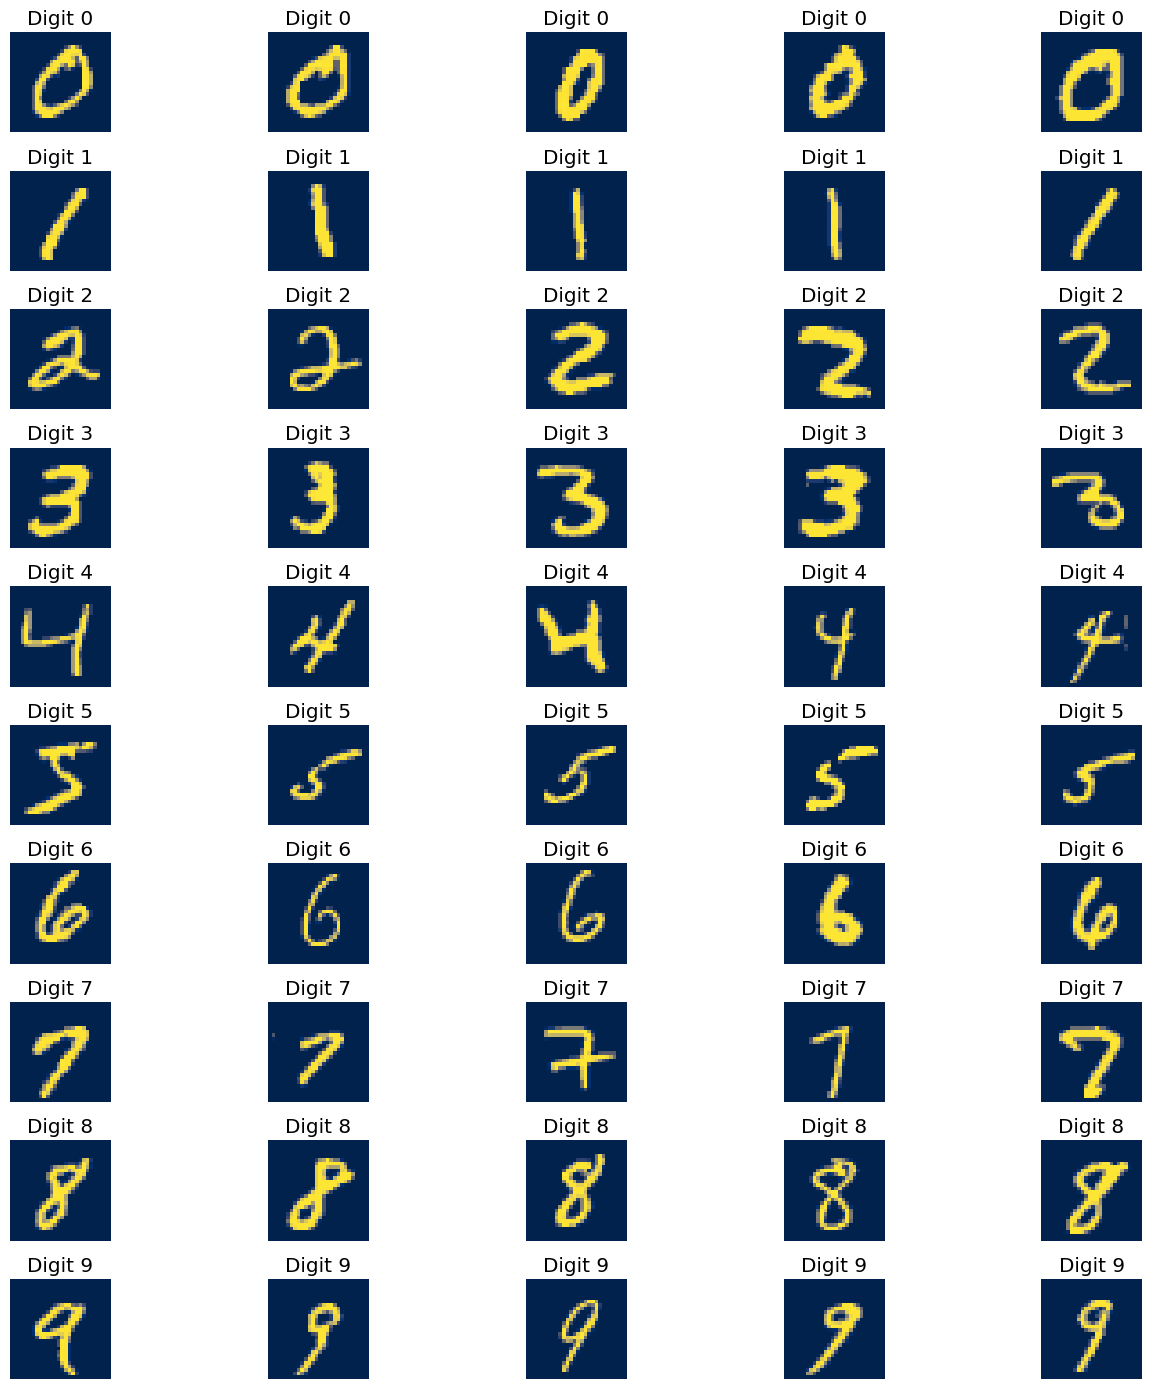

In [46]:
###################################################
## Visualize 5 samples from each class (1 point) ##
##################[Your Code]######################
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(10, 5, figsize=(14, 14))

for digit in range(10):
    digit_indices = np.where(y_train == digit)[0][:5]
    
    for i, idx in enumerate(digit_indices):
        axes[digit, i].imshow(x_train[idx].reshape(28, 28), cmap='cividis')  # Changed color map to 'cividis'
        axes[digit, i].set_title(f"Digit {digit}")
        axes[digit, i].axis('off')
        
plt.tight_layout()
plt.show()


Now normalize the data (mean=0 and std=1) and also flattern the input because we have just linear layers and we need two have a vector as input.

In [47]:
#####################################################
##        Normalize and flatten X (2 points)       ##
####################[Your Code]######################
x_train_normalized = (x_train - np.mean(x_train, axis=0)) / (np.std(x_train, axis=0) + 1e-8)
x_val_normalized = (x_val - np.mean(x_train, axis=0)) / (np.std(x_train, axis=0) + 1e-8)
x_test_normalized = (x_test - np.mean(x_train, axis=0)) / (np.std(x_train, axis=0) + 1e-8)
x_train_normalized = x_train.reshape(x_train.shape[0], -1)
x_val_normalized = x_val.reshape(x_val.shape[0], -1)
x_test_normalized = x_test.reshape(x_test.shape[0], -1)

#####################################################
# Print shapes to verify
print(f"x_train shape = {x_train_normalized.shape}, x_val shape = {x_val_normalized.shape}, x_test shape = {x_test_normalized.shape}")

x_train shape = (42000, 784), x_val shape = (14000, 784), x_test shape = (14000, 784)


## Train and Test Model (35 Points)

### Batch Sampler (10 Points)
We need to sample bathces from our dataset to train model. Complete the following class to have a random sampler (8 Points).

In [48]:
class RandomSampler(object):
    def __init__(self, batch_size, dataset, dtype):
        """
        Args:
            batch_size : sampler batch size
            dataset : dataset we want to get batch from that
            dtype : one of {'train', 'test', 'val'}
        """
        #####################################################
        ##          Initialize your RandomSampler          ##
        ####################[Your Code]######################
        
        self.batch_size = batch_size
        self.dataset = dataset
        self.dtype = dtype
        
        self.data, self.labels = dataset[0], dataset[1]
        
        self.num_batches = len(self.data) // self.batch_size


    def __len__(self):
        #####################################################
        ##          Return length of your sampler          ##
        ####################[Your Code]######################

        return self.num_batches

    def __iter__(self):
        """
        This function is called when we iterate an object of this class and
        yields one batch on each call.

        Yields:
            (x, y) : tuple of bathces of x and y
        """
        #######################################################
        ##  Yield a tuple of x and y from specified dataset  ##
        #####################[Your Code]#######################
        indices = np.arange(len(self.data))
        np.random.shuffle(indices)
        
        for start_idx in range(0, len(self.data), self.batch_size):
            end_idx = start_idx + self.batch_size
            if end_idx > len(self.data):
                break
            
            batch_indices = indices[start_idx:end_idx]
            yield self.data[batch_indices], self.labels[batch_indices]

Fill the following functions to update a confusion matrix and calculate f1 score for a confusion matrix (2 Points).

In [49]:
def update_confusion_matrix(conf_matrix, preds, reals):
    """
    Updates confusion matrix

    Args:
        conf_matrix : input confusion matrix
        preds : array of predicted labels
        reals : array of real labels

    Returns:
        conf_matrix : updated confusion matrix
    """
    #######################################################
    ##           Update the confusion matrix             ##
    #####################[Your Code]#######################

    for real, pred in zip(reals, preds):
        conf_matrix[real, pred] += 1
        
    return conf_matrix


def f1_score(confusion_matrix):
    """
    calculate macro f1 score from given confusion matrix

    Args:
        confusion_matrix : given confusion matrix

    Returns:
        f1 : macro f1 score
    """
    #######################################################
    ##                Calculate f1 score                 ##
    #####################[Your Code]#######################

    num_classes = confusion_matrix.shape[0]
    f1_scores = []

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = np.sum(confusion_matrix[:, i]) - tp
        fn = np.sum(confusion_matrix[i, :]) - tp
        if tp + fp > 0:
            precision = tp / (tp + fp)
        else:
            precision = 0
        if tp + fn > 0:
            recall = tp / (tp + fn)
        else:
            recall = 0
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        f1_scores.append(f1)

    return np.mean(f1_scores)

### Define Model (5 Points)
Define an MLP model to solve the classification problem. Try to define a good initializer function (not just a simple random initializer)

In [50]:
def initializer(x, y):
    #######################################################
    ##         Define your initilizer (1 Point)          ##
    #####################[Your Code]#######################
    
    std_dev = np.sqrt(2 / x)
    return np.random.normal(0, std_dev, size=(x, y))


model = MLPModel([
    #######################################################
    ##           Define your model (1 Point)             ##
    #####################[Your Code]#######################
    LinearLayer(784, 256, initializer=initializer, reg=True, alpha=0.001),
    Dropout(0.2),
    ReLU(),
    BatchNorm(256),
    LinearLayer(256, 128, initializer=initializer, reg=True, alpha=0.001),
    ReLU(),
    BatchNorm(128),
    LinearLayer(128, 10, initializer=initializer, reg=True, alpha=0.001),
    LogSoftMax()
])

In [51]:
#######################################################
##           Initialize hyperparameters              ##
#####################[Your Code]#######################

n_epochs = 15
batch_size = 64

def lr(epoch):
    #######################################################
    ## Define LR Scheduler for your optimizer (2 Points) ##
    #####################[Your Code]#######################
    
    return 0.09 / (1 + 0.6* epoch)

In [52]:
##################################################
## Define optimizer, loss and sampler (1 Point) ##
##################[Your Code]#####################
optimizer = Optimizer(
    layers=model.get_parameters(),
    strategy='adam',
    lr=lr
)

cross_entropy = CrossEntropyLoss()



### Train Model (17 Points)

Fill in the below cell to train the model. Store each epoch loss, accuracy and f1-score. Use f1-score to choose best epoch.

**Note1**: To do backpropagation you need to first call `backward` function of criterion with 1 as its argument to have gradient of loss w.r.t output of this module and then using model `backward` function with `criterion.grads['x']` argument.

**Note2**: You can ignore regularization term in your total loss value and just use criterion, but you must consider that during updating.

In [53]:
##################################################
##    Train and validation loop (15 Points)     ##
##################[Your Code]#####################

train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1, val_f1 = [], []
best_model = None
best_f1 = 0

train_metrics_list = []
val_metrics_list = []

train_sampler = RandomSampler(batch_size, (x_train_normalized, y_train), 'train')
val_sampler = RandomSampler(batch_size, (x_val_normalized, y_val), 'val')

for epoch in range(n_epochs):
        ##################################################
        ##                 Train Phase                  ##
        ##################[Your Code]#####################
        
    epoch_train_loss = 0.0
    epoch_train_conf_matrix = np.zeros((10, 10), dtype=int)

    for x_batch, y_batch in train_sampler:
        predictions = model._forward(x_batch, mode='train')
        
        train_loss = cross_entropy._forward(predictions, y_batch)
        epoch_train_loss += train_loss
        
        upstream_grad = 1
        cross_entropy.backward(upstream_grad)
        model.backward(cross_entropy.grads['x'])
        
        optimizer.step(epoch)
        
        epoch_train_conf_matrix = update_confusion_matrix(epoch_train_conf_matrix, 
                                                         np.argmax(predictions, axis=1), 
                                                         y_batch)
    
    epoch_train_loss /= len(train_sampler)
    train_losses.append(epoch_train_loss)
    
    epoch_train_acc = np.trace(epoch_train_conf_matrix) / np.sum(epoch_train_conf_matrix)
    train_accs.append(epoch_train_acc)
    
    epoch_train_f1 = f1_score(epoch_train_conf_matrix)
    train_f1.append(epoch_train_f1)

        ##################################################
        ##      Save epoch metrics for train phase      ##
        ##################[Your Code]#####################
        
    train_metrics = {
        'epoch': epoch + 1,
        'loss': epoch_train_loss,
        'accuracy': epoch_train_acc,
        'f1_score': epoch_train_f1
    }
    train_metrics_list.append(train_metrics)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Train - Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.4f}, F1-score: {epoch_train_f1:.4f}")
    
        ##################################################
        ##               Validation Phase               ##
        ##################[Your Code]#####################
    
    epoch_val_loss = 0.0
    epoch_val_conf_matrix = np.zeros((10, 10), dtype=int)

    for x_batch, y_batch in val_sampler:
        predictions = model._forward(x_batch, mode='valid')
        
        val_loss = cross_entropy._forward(predictions, y_batch)
        epoch_val_loss += val_loss
        
        epoch_val_conf_matrix = update_confusion_matrix(epoch_val_conf_matrix, 
                                                       np.argmax(predictions, axis=1), 
                                                       y_batch)
    
    epoch_val_loss /= len(val_sampler)
    val_losses.append(epoch_val_loss)
    
    epoch_val_acc = np.trace(epoch_val_conf_matrix) / np.sum(epoch_val_conf_matrix)
    val_accs.append(epoch_val_acc)
    
    epoch_val_f1 = f1_score(epoch_val_conf_matrix)
    val_f1.append(epoch_val_f1)

        ##################################################
        ##    Save epoch metrics for validation phase   ##
        ##################[Your Code]#####################
        
    validation_metrics = {
        'epoch': epoch + 1,
        'loss': epoch_val_loss,
        'accuracy': epoch_val_acc,
        'f1_score': epoch_val_f1
    }
    val_metrics_list.append(validation_metrics)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Validation - Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}, F1-score: {epoch_val_f1:.4f}")

        ##################################################
        ##          Save best model and best f1         ##
        ##################[Your Code]#####################
    
    if epoch_val_f1 > best_f1:
        best_f1 = epoch_val_f1
        best_model = model
        
print(f"Best validation F1-score: {best_f1:.4f} at epoch {np.argmax(val_f1) + 1}")

Epoch [1/15], Train - Loss: 14.6442, Accuracy: 0.2280, F1-score: 0.1878
Epoch [1/15], Validation - Loss: 25.1651, Accuracy: 0.1547, F1-score: 0.0843
Epoch [2/15], Train - Loss: 12.3048, Accuracy: 0.3803, F1-score: 0.2846
Epoch [2/15], Validation - Loss: 16.9874, Accuracy: 0.2818, F1-score: 0.1845
Epoch [3/15], Train - Loss: 9.9564, Accuracy: 0.4631, F1-score: 0.3466
Epoch [3/15], Validation - Loss: 12.7952, Accuracy: 0.4149, F1-score: 0.3206
Epoch [4/15], Train - Loss: 8.5303, Accuracy: 0.4958, F1-score: 0.3720
Epoch [4/15], Validation - Loss: 9.5951, Accuracy: 0.4799, F1-score: 0.3689
Epoch [5/15], Train - Loss: 8.0530, Accuracy: 0.5120, F1-score: 0.3852
Epoch [5/15], Validation - Loss: 8.4471, Accuracy: 0.5003, F1-score: 0.3824
Epoch [6/15], Train - Loss: 7.8245, Accuracy: 0.5208, F1-score: 0.3912
Epoch [6/15], Validation - Loss: 7.5563, Accuracy: 0.4809, F1-score: 0.3821
Epoch [7/15], Train - Loss: 7.3232, Accuracy: 0.5606, F1-score: 0.4567
Epoch [7/15], Validation - Loss: 6.5175, A

In [54]:
##################################################################################################
## Plot train and validation loss, accuracy and f1 graphs and lr value at each epoch (2 Points) ##
#######################################[Your Code]################################################



### Test Model (3 Points)

In [55]:
############################################################
##                  Test your best model                  ##
##          Report loss, accuracy and f1 metrics          ##
##      Also plot the confusion matrix for test data      ##
#######################[Your Code]##########################

